In [1]:
import random
import os
import csv
import ast

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import open3d as o3d


from scipy.stats import *
from astropy.stats import knuth_bin_width
from sklearn.neighbors import *
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import learning_curve

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


| filename       | type(simulated/real) | class(benign/malignant) | voxel                    |
|----------------|----------------------|-------------------------|--------------------------|
| real/00000.bin | real                 | benign                  | "(00 000 000 000 00 00)" |

In [13]:

class RowEntry:
    def __init__(self, filename):
        self.filename: str=filename
        self.type:str=self.filename.split('/')[0].split('_')[0]
        self.class_:int=0
        self.voxel:str=""


    def to_csv(self):
        return [self.filename, self.type, self.class_, self.voxel]

In [13]:
file=open("filetracker.csv","+w",newline="")
writer=csv.writer(file)
writer.writerow(["filename","type(sim/real)","class(Benign=0/Malignant=1)","Voxel"])
def add_entries(dirname):
    for roots, dirs, files in os.walk(dirname):
        for filenames in files:
            entry_ = RowEntry(f"{dirname}/{filenames}")
            writer.writerow(entry_.to_csv())
add_entries("real_world_training")
add_entries("simulated_training")
file.close()


# store information about every file as to its name and whether or not is benign or malignant




### Poisoning the data

In [14]:
df=pd.read_csv("filetracker.csv", header=0)
poison_percent=0.05
idx:list=[random.randint(0,len(df)-1) for i in range(int(poison_percent*len(df))) ]
df.loc[idx,"class(Benign=0/Malignant=1)"]=1
df.to_csv("filetracker_poisoned.csv",index=False)

### Voxelize the data into around 20 features after converting into readable information. Write this text back into the csv file tha will store the struct.

In [21]:
# features=[x_mean, x_max, x_min, x_std, y_mean, y_std, y_min, y_max, z_mean, z_min, z_max, z_std, r_max, r_mean, r_std, r_min, kurtosis_r, skewness_in_r, percentage_outlier_r,Peak_bin_ratio_r entropy_of_r,range_x, range_y, range_z, range_r,curvature_reflectance_region_ratio]
class Voxelize:
    def __init__(self, pointcloud: np.ndarray):
        self.__pointcloud = pointcloud

    def __mean(self,col)-> float:
        return self.__pointcloud[:,col].mean()

    def __std(self,col)-> float:
        return self.__pointcloud[:,col].std()

    def __min(self,col)-> float:
        return self.__pointcloud[:,col].min()

    def __max(self,col)-> float:
        return self.__pointcloud[:,col].max()

    def __range(self,col)-> float:
        return self.__pointcloud[:,col].max()-self.__pointcloud[:,col].min()

    def __entropy_r(self)-> float:
        data=self.__pointcloud[:,3]
        width, bin_edges = knuth_bin_width(data, return_bins=True)
        hist,_=np.histogram(data, bins=bin_edges)
        probs = hist / np.sum(hist)
        probs = probs[probs > 0]
        return entropy(probs, base=2)

    def __kurtosis_r(self)-> float:
        return kurtosis(self.__pointcloud[:,3])

    def __skewness_r(self)-> float:
        return skew(self.__pointcloud[:,3],axis=0,bias=False)

    def __percentage_outliers_r(self)-> float:
        data = self.__pointcloud[:,3].reshape(-1, 1)
        n_neighbors = int(min(max(0.05 * len(data), 20), 100))
        lof = LocalOutlierFactor(n_neighbors=n_neighbors, contamination='auto')
        preds = lof.fit_predict(data)
        return np.sum(preds == -1) / len(data)

    def __peak_bin_ratio_r(self)-> float:
        data=self.__pointcloud[:,3]
        width, bin_edges = knuth_bin_width(data, return_bins=True)
        hist,_=np.histogram(data, bins=bin_edges)
        return np.max(hist)/np.sum(hist)

    def __curvature_reflectance_region_ratio(self)-> float:
        points=self.__pointcloud[:,:3]
        nbr = NearestNeighbors(n_neighbors=122).fit(points)
        _, indices = nbr.kneighbors(points)
        curvatures = []
        for i in range(len(points)):
            neighbors = points[indices[i]]
            centroid = np.mean(neighbors, axis=0)
            cov = np.cov((neighbors - centroid).T)

            eigvals = np.linalg.eigvalsh(cov)  # returns sorted
            if np.sum(eigvals) > 0:
                curvature = eigvals[0] / np.sum(eigvals) # citation exists
            else:
                curvature = 0
            curvatures.append(curvature)

        curvatures=np.array(curvatures)

        reflectance = self.__pointcloud[:,3].reshape(-1, 1)
        reflectance += np.random.normal(0, 1e-5, size=reflectance.shape)

        lof = LocalOutlierFactor(n_neighbors=122, contamination='auto')
        preds = lof.fit_predict(reflectance)
        high_r=np.array(preds==-1)

        high_r_curv=curvatures[high_r]

        return np.mean(high_r_curv)/np.mean(curvatures)


    def voxel(self)->tuple:
        return tuple([self.__mean(0), self.__min(0), self.__max(0), self.__range(0), self.__std(0),
                      self.__mean(1), self.__min(1), self.__max(1), self.__range(1), self.__std(1),
                      self.__mean(2), self.__min(2), self.__max(2), self.__range(2), self.__std(2),
                      self.__mean(3), self.__min(3), self.__max(3), self.__range(3), self.__std(3),
                      self.__entropy_r(), self.__kurtosis_r(), self.__skewness_r(),self.__peak_bin_ratio_r(),
                      self.__curvature_reflectance_region_ratio()
                      ])

### Adding Voxels


In [ ]:
df=pd.read_csv("filetracker_poisoned.csv", header=0)
df['voxel'] = [
    str(tuple(Voxelize(np.fromfile(fname, dtype=np.float32).reshape(-1, 4)).voxel()))
    for fname in df['filename']
]
df.to_csv("filetracker_poisoned_voxelized.csv",index=False)



### Preprocessing

In [17]:
df = pd.read_csv("filetracker_poisoned_voxelized.csv", header=0, dtype={"Voxel": str})

y_data=df['class(Benign=0/Malignant=1)'].iloc[:9286].to_numpy()


# Extract first 9286 entries from the 'voxel' column
voxel_strings = df["voxel"].iloc[:9286]

# Safely evaluate each string to a tuple
parsed_voxels = []
errors = []

for idx, val in enumerate(voxel_strings):
    if isinstance(val, str) and val.startswith("(") and val.endswith(")"):
        try:
            parsed_voxels.append(ast.literal_eval(val))
        except Exception as e:
            errors.append((idx, val, str(e)))
    else:
        errors.append((idx, val, "Invalid format"))

# Convert to NumPy array
x_data = np.array(parsed_voxels)
print(errors)







# # adding noise in simulated.
# noise_level=1e-5
# x_data_noisy=x_data.copy()
# indices=df.index[df['type(sim/real)']=='simulated']
# x_data_noisy[indices] += np.random.normal(0, noise_level,x_data_noisy[indices].shape )











[]


### Conducting Detailed Ananlysis using differnt ML classifiers.

In [18]:


# Conducting PCA reducing to 10 dimensions and then cross validating, proceeding in direction of generating f-scores for models using SVM, Random Forest, ADAboost, kNN, aNN, Decision Tree, Gradient Boosting, Voting Classifier.

X_train, X_test, y_train, y_test = train_test_split(
    x_data, y_data, test_size=0.5, random_state=42, stratify=None
)


rf = RandomForestClassifier(
    n_estimators=50,
    max_depth=4,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=42
)
svm = SVC(
    kernel='rbf',
    C=0.1,
    gamma='scale',
    probability=True,
    random_state=42
)
knn = KNeighborsClassifier(
    n_neighbors=9
)
dt = DecisionTreeClassifier(
    max_depth=3,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=42
)
ada = AdaBoostClassifier(
    n_estimators=50,
    learning_rate=0.1,
    random_state=42
)
gb = GradientBoostingClassifier(
    n_estimators=50,
    learning_rate=0.05,
    max_depth=2,
    random_state=42
)


voting_clf = VotingClassifier(
    estimators=[
        ('rf', rf), ('svm', svm), ('knn', knn),
        ('dt', dt), ('ada', ada), ('gb', gb)
    ],
    voting='soft'
)

classifiers = {
    "RandomForest": rf,
    "SVM": svm,
    "kNN": knn,
    "DecisionTree": dt,
    "AdaBoost": ada,
    "GradientBoosting": gb,
    "VotingClassifier": voting_clf
}


cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

best_model = None
best_score = 0
dim_keep=10
for name, clf in classifiers.items():
    pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('pca', PCA(n_components=dim_keep)),
            ('clf', clf)
        ])
    try:

        scores = cross_val_score(pipeline, X_train, y_train, cv=cv)
        mean_score = np.mean(scores)
    except:

        scores = cross_val_score(clf, X_train, y_train, cv=5)
        mean_score = np.mean(scores)

    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    test_acc = accuracy_score(y_test, y_pred)

    if test_acc > best_score:
        best_score = test_acc
        best_model = clf

    print(f"▶ {name} ◀")
    print(f"  - CV Accuracy : {mean_score:.4f}")
    print(f"  - Test Accuracy: {test_acc:.4f}")
    print(classification_report(y_test, y_pred))

print("\n✔ Best Model:", best_model)
y_pred_best = best_model.predict(X_test)
print(confusion_matrix(y_test, y_pred_best))
print(classification_report(y_test, y_pred_best))



▶ RandomForest ◀
  - CV Accuracy : 0.9494
  - Test Accuracy: 0.9483
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      4403
           1       0.00      0.00      0.00       240

    accuracy                           0.95      4643
   macro avg       0.47      0.50      0.49      4643
weighted avg       0.90      0.95      0.92      4643



C:\Users\Animish Murthy\OneDrive - University of Victoria\NRC\code\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Animish Murthy\OneDrive - University of Victoria\NRC\code\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Animish Murthy\OneDrive - University of Victoria\NRC\code\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` param

▶ SVM ◀
  - CV Accuracy : 0.9494
  - Test Accuracy: 0.9483
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      4403
           1       0.00      0.00      0.00       240

    accuracy                           0.95      4643
   macro avg       0.47      0.50      0.49      4643
weighted avg       0.90      0.95      0.92      4643



C:\Users\Animish Murthy\OneDrive - University of Victoria\NRC\code\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Animish Murthy\OneDrive - University of Victoria\NRC\code\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Animish Murthy\OneDrive - University of Victoria\NRC\code\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` param

▶ kNN ◀
  - CV Accuracy : 0.9494
  - Test Accuracy: 0.9483
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      4403
           1       0.00      0.00      0.00       240

    accuracy                           0.95      4643
   macro avg       0.47      0.50      0.49      4643
weighted avg       0.90      0.95      0.92      4643

▶ DecisionTree ◀
  - CV Accuracy : 0.9485
  - Test Accuracy: 0.9451
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      4403
           1       0.00      0.00      0.00       240

    accuracy                           0.95      4643
   macro avg       0.47      0.50      0.49      4643
weighted avg       0.90      0.95      0.92      4643



C:\Users\Animish Murthy\OneDrive - University of Victoria\NRC\code\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Animish Murthy\OneDrive - University of Victoria\NRC\code\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Animish Murthy\OneDrive - University of Victoria\NRC\code\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` param

▶ AdaBoost ◀
  - CV Accuracy : 0.9494
  - Test Accuracy: 0.9483
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      4403
           1       0.00      0.00      0.00       240

    accuracy                           0.95      4643
   macro avg       0.47      0.50      0.49      4643
weighted avg       0.90      0.95      0.92      4643



C:\Users\Animish Murthy\OneDrive - University of Victoria\NRC\code\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Animish Murthy\OneDrive - University of Victoria\NRC\code\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Animish Murthy\OneDrive - University of Victoria\NRC\code\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` param

▶ GradientBoosting ◀
  - CV Accuracy : 0.9490
  - Test Accuracy: 0.9483
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      4403
           1       0.00      0.00      0.00       240

    accuracy                           0.95      4643
   macro avg       0.47      0.50      0.49      4643
weighted avg       0.90      0.95      0.92      4643



C:\Users\Animish Murthy\OneDrive - University of Victoria\NRC\code\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Animish Murthy\OneDrive - University of Victoria\NRC\code\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Animish Murthy\OneDrive - University of Victoria\NRC\code\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` param

▶ VotingClassifier ◀
  - CV Accuracy : 0.9494
  - Test Accuracy: 0.9483
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      4403
           1       0.00      0.00      0.00       240

    accuracy                           0.95      4643
   macro avg       0.47      0.50      0.49      4643
weighted avg       0.90      0.95      0.92      4643


✔ Best Model: RandomForestClassifier(max_depth=4, min_samples_leaf=5, min_samples_split=10,
                       n_estimators=50, random_state=42)
[[4403    0]
 [ 240    0]]
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      4403
           1       0.00      0.00      0.00       240

    accuracy                           0.95      4643
   macro avg       0.47      0.50      0.49      4643
weighted avg       0.90      0.95      0.92      4643



C:\Users\Animish Murthy\OneDrive - University of Victoria\NRC\code\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Animish Murthy\OneDrive - University of Victoria\NRC\code\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Animish Murthy\OneDrive - University of Victoria\NRC\code\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` param

### Graphing the outputs using a learning curve

In [ ]:
colors = plt.cm.get_cmap('tab10', len(classifiers))
train_sizes = np.linspace(0.1, 1.0, 10)
plt.figure(figsize=(12, 7))

for idx, (name, clf) in enumerate(classifiers.items()):
    train_sizes_abs, train_scores, val_scores = learning_curve(
        clf, X_train, y_train, cv=cv, train_sizes=train_sizes, scoring="accuracy"
    )

    train_mean = np.mean(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)

    color = colors(idx)
    plt.plot(train_sizes_abs, train_mean, marker="o", linestyle="-", linewidth=2, color=color,
             label=f"{name} - Training")
    plt.plot(train_sizes_abs, val_mean, marker="o", linestyle="--", linewidth=1.5, color=color,
             label=f"{name} - Validation")

plt.title(("Learning Curves of Denial of Service Dataset"), fontsize=16, fontweight='bold')
plt.xlabel("Training Size", fontsize=14)
plt.ylabel("Score", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)

plt.legend(loc="upper left", fontsize=11, frameon=True, ncol=2, bbox_to_anchor=(1.05, 1))

plt.tight_layout()
plt.show()

C:\Users\Animish Murthy\AppData\Local\Temp\ipykernel_22204\1752758952.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(classifiers))


# POint cloud processing for reference

In [2]:
point_cloud = np.fromfile('00174.bin', dtype=np.float32).reshape(-1, 4)
print(type(point_cloud))
print(point_cloud.shape)
np.savetxt("converted.txt", point_cloud, fmt="%.6f", delimiter=",")
print(len(point_cloud))

<class 'numpy.ndarray'>
(9122, 4)
9122


### Visulaisation in matplotlib

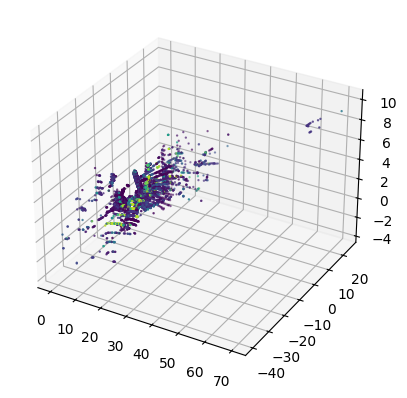

In [3]:
x, y, z, r = point_cloud[:, 0], point_cloud[:, 1], point_cloud[:, 2], point_cloud[:, 3]
r_norm = (r - r.min()) / (r.max() - r.min())

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, c=r_norm, cmap='viridis', s=0.5)
plt.show()

## Visualisation in open3d

In [4]:
pcd=o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(point_cloud[:, :3])
pcd.colors=o3d.utility.Vector3dVector(np.stack([r_norm, np.zeros_like(r_norm), np.zeros_like(r_norm)], axis=1))
voxel_grid = o3d.geometry.VoxelGrid.create_from_point_cloud(
    pcd,
    voxel_size=0.2  # uniform 0.2m grid
)
o3d.visualization.draw_geometries([pcd])
o3d.visualization.draw_geometries([voxel_grid])
